### Computational Vision Lectures 7 and 8
### Edge detection and Hough Transform Demo
### February 7, 2022


In [1]:
'''
Start with the usual imports, although I've added few that our particular to the class.
'''
import cv2
import numpy as np
from matplotlib import pyplot as plt

import resize_img
import math as m
import image_plot_utilities as ipu


---
Let's import an image and resize it 

In [2]:
im_name ='Municipal_Building_-_New_York_City.jpg'
im = cv2.imread(im_name, cv2.IMREAD_GRAYSCALE)
im = np.rot90(im)
im = resize_img.resize_img(im,1000)


(750, 1000)


---

We'll run Gaussian smoothing, gradient computation, and look at the results.  For the x and y derivatives, notice that the 0 value is gray in the plot because there are negative values and pyplot automatically shifts the intensity scale to make sure all values plotted are positive.

float64
Here are the derivative kernels
[[-0.5  0.   0.5]]
[[-0.5]
 [ 0. ]
 [ 0.5]]
float64
2 2 1
2 2 2
2 2 3
2 2 4


<Figure size 432x288 with 0 Axes>

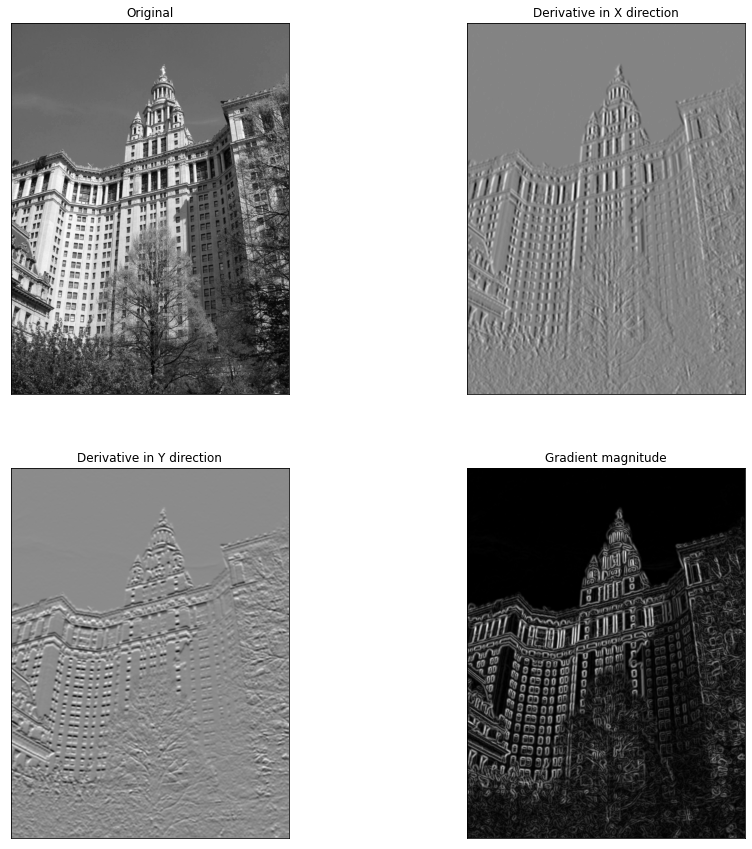

In [3]:
sigma = 2
ksize = (4*sigma+1,4*sigma+1)
im_s = cv2.GaussianBlur(im.astype(float), ksize, sigma)
print(im_s.dtype)

kx,ky = cv2.getDerivKernels(1,1,3)
kx = np.transpose(kx/2)
ky = ky/2
print('Here are the derivative kernels')
print(kx)
print(ky)
im_dx = cv2.filter2D(im_s,-1,kx)
print(im_dx.dtype)
im_dy = cv2.filter2D(im_s,-1,ky)
im_gm = np.sqrt(im_dx**2 + im_dy**2)   # gradient magnitude

img_list = [im, im_dx, im_dy, im_gm]
num_in_col = 2
titles = ['Original', 'Derivative in X direction', 'Derivative in Y direction', 'Gradient magnitude']

ipu.plot_pics( img_list, num_in_col, titles)

---
Let's take a closer look at the gradient magnitude image and then the gradient direction.

(1000, 750)
1 2 1


<Figure size 432x288 with 0 Axes>

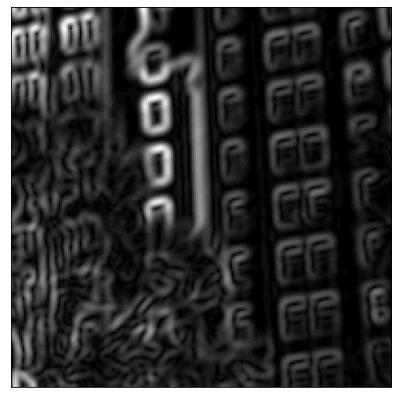

In [4]:
cy, cx = im_gm.shape[0]//2, im_gm.shape[1]//2
dim = 200
y0,x0 = cy- dim//2, cx-dim//2
print(im_gm.shape)

win_im_gm = im_gm[cy:cy+dim, cx:cx+dim]
win_im_gm = win_im_gm.astype(np.uint8)
ipu.plot_pics([win_im_gm])

# win_im_gm = (win_im_gm.astype(np.uint8)
# ipu.show_with_pixel_values(ipu.get_image_to_show(win_im_gm))


---

Now let's look at what happens when we apply thresholding.  At the moment, we don't have much of an idea
of what a good threshold might be, so we'll try several.  The Canny edge detector and many of its variations
have reasonably intelligent thresholding methods.  Here, we'll threshold so that 2.5%, 7.5%, and 15% of the points
are retained.  You'll notice that we end up with missing edges and thick edges.  We have to handle both of these issues.

18750 22
56250 15
112500 10
2 2 1
2 2 2
2 2 3
2 2 4


<Figure size 432x288 with 0 Axes>

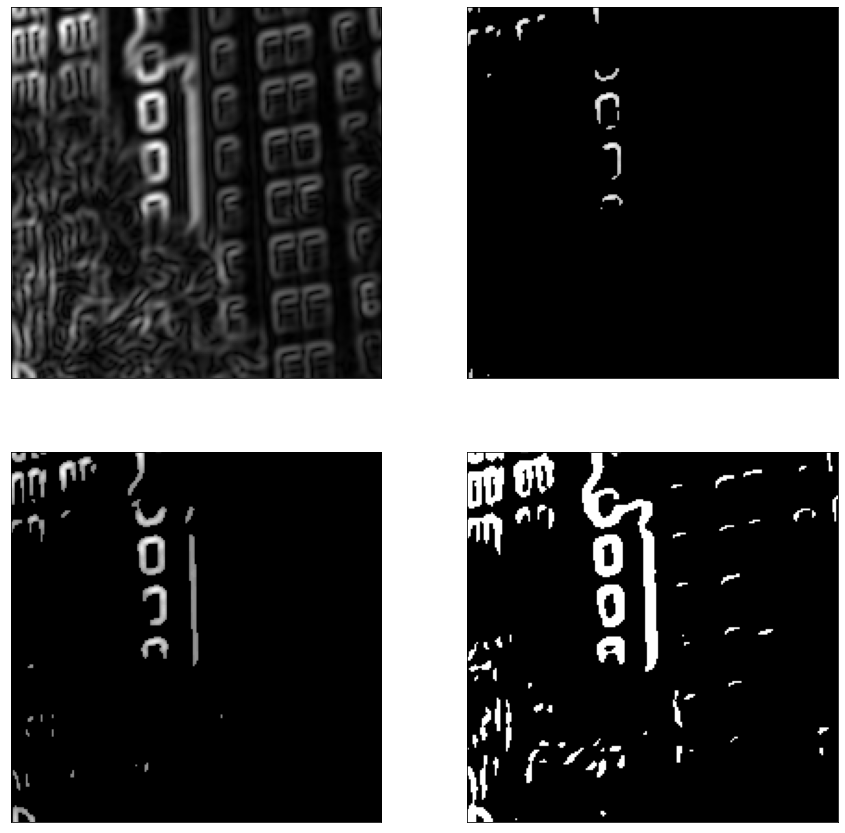

In [5]:
im_gm_int = im_gm.astype(np.uint8)
gradients = np.sort(im_gm_int, axis=None)[::-1]   # This flattens before sorting and then reverses the order

index1 = int(0.025 * len(gradients))
print(index1, gradients[index1])
rv,im_thresh1 = cv2.threshold(im_gm_int, gradients[index1], 255., cv2.THRESH_TOZERO)

index2 = int(0.075 * len(gradients))
print(index2, gradients[index2])
rv,im_thresh2 = cv2.threshold(im_gm_int, gradients[index2], 255, cv2.THRESH_TOZERO)

index3 = int(0.15* len(gradients))
print(index3, gradients[index3])
rv,im_thresh3 = cv2.threshold(im_gm_int, gradients[index3], 255, cv2.THRESH_BINARY)

win_im_gm = im_gm[cy:cy+dim,cx:cx+dim]
win_thresh1 = im_thresh1[cy:cy+dim,cx:cx+dim]
win_thresh2 = im_thresh2[cy:cy+dim,cx:cx+dim]
win_thresh3 = im_thresh3[cy:cy+dim,cx:cx+dim]
ipu.plot_pics( [win_im_gm, win_thresh1, win_thresh2, win_thresh3], num_in_col=2)


### Canny edge detection
The Canny edge detector, originally described over 30 years ago, remains the standard edge detection algorithm.  It includes all of the methods we discussed in lecture.  Here is an example of running the OpenCV version of this edge detector.  We'll play with threshold values in class.

The two arguments after the image are the low and high thresholds for the hysteresis thresholding described in class.  You'll notice that there is no ability to set the Gaussian smoothing standard deviation, sigma.  You can create the effect of this by pre-filtering the image with Gaussian smoothing.  However, the Canny code does require that the images are in uint8 format, so after Gaussian smoothing (usually done as float), one does have to make sure the images are in the right format.

(600, 800)
1 2 1
1 2 2


<Figure size 432x288 with 0 Axes>

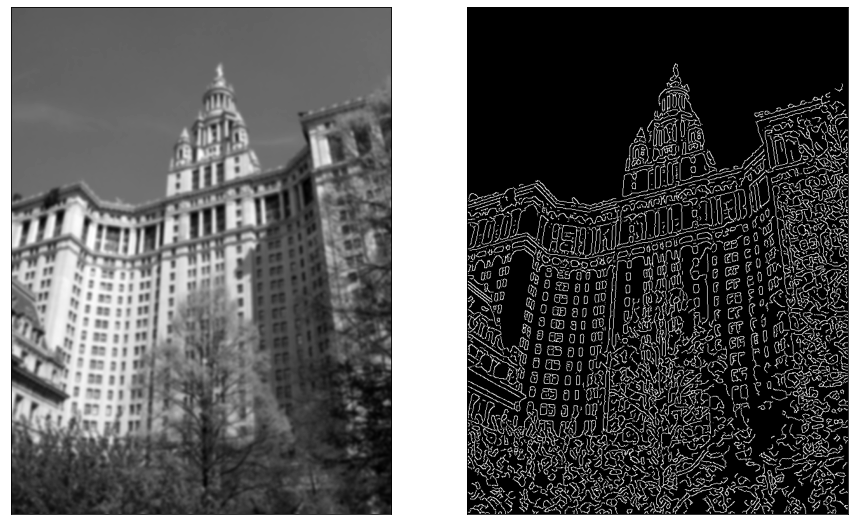

In [6]:
im_name ='Municipal_Building_-_New_York_City.jpg'
im = cv2.imread(im_name,cv2.IMREAD_GRAYSCALE)
im = np.rot90(im)
im = resize_img.resize_img(im,800)

low_thresh = 50
high_thresh = 100

smooth_first = True
if smooth_first:
    im = im.astype(float)
    sigma = 2
    low_thresh, high_thresh = low_thresh/2, high_thresh/2
    ksize = (4*sigma+1,4*sigma+1)
    im = cv2.GaussianBlur(im, ksize, sigma).astype(np.uint8)

edge_im = cv2.Canny(im, low_thresh, high_thresh)
ipu.plot_pics( [im, edge_im])

### Hough Transform:  Plotting rho as a function of theta for fixed x and y

The following code shows examples of all possible lines that can pass through a particular point (x,y).  Using the polar coordinate form of the line, we have the line equation as

$ x \cos(\theta) + y \sin(\theta) - \rho = 0,$

where $\theta$ ranges over 0 to $2\pi$, while $\rho$ must be non-negative.  For fixed x,y we can express all possible lines as

$ \rho = x \cos(\theta) + y \sin(\theta)$

and therefore plot $\rho$ as a function of $\theta$.  The result is a sinusoid.

Below we'll plot one example, and modify it only allow non-negative rho.  Then we'll add points and show what happens.

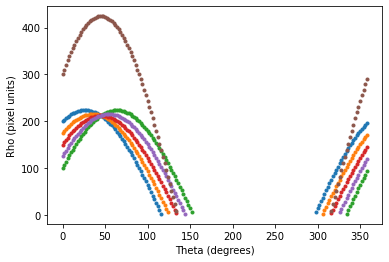

In [7]:
from matplotlib import pyplot as plt

def gen_plot(x, y):
    thetas = np.linspace(0, 2*m.pi, 180, endpoint=False)
    rhos = x*np.cos(thetas) + y*np.sin(thetas)
    thetas *= 180 / m.pi
    thetas = thetas[np.where(rhos>=0)]
    rhos = rhos[np.where(rhos>=0)]
    plt.scatter(thetas, rhos, marker='.')

gen_plot(200, 100)
gen_plot(175, 125)
gen_plot(100, 200)
gen_plot(150, 150)
gen_plot(125, 175)
gen_plot(300, 300)
plt.xlabel('Theta (degrees)')
plt.ylabel('Rho (pixel units)')
plt.show()
    


### Checkerboards and Edges and Hough Transforms
Now we'll play with a checkerboard image to try to understand edge detection performance a little better, and introduce the use of the Hough transform.

(523, 742)
(523, 742)
1 2 1
1 2 2


<Figure size 432x288 with 0 Axes>

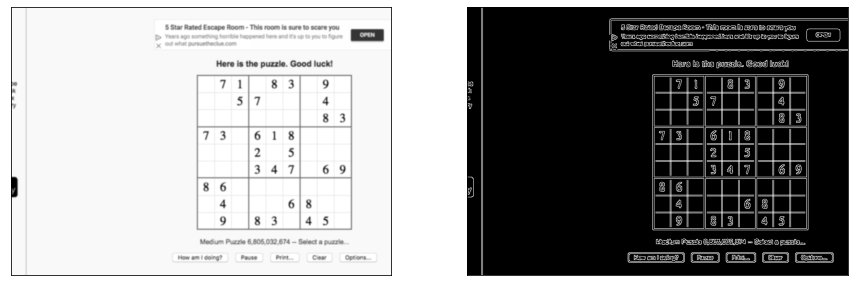

In [8]:
im = cv2.imread('s1.png', cv2.IMREAD_GRAYSCALE)
print(im.shape)
im = resize_img.resize_img(im,800)
low_thresh, high_thresh = 10,20

smooth_first = True
if smooth_first:
    im = im.astype(float)
    sigma = 1
    low_thresh, high_thresh = low_thresh/2, high_thresh/2
    ksize = (4*sigma+1,4*sigma+1)
    im = cv2.GaussianBlur(im, ksize, sigma).astype(np.uint8)
    
edge_im = cv2.Canny(im, low_thresh, high_thresh)
print(im.shape)
ipu.plot_pics( [im, edge_im])

### Now the Hough Transform
Now onto the OpenCV implementation of the Hough transform. There are two versions of this for fitting lines. The first, cv2.HoughLines returns a list of the rho, theta values that define the lines with no endpoints on the line. The second, cvs.HoughLinesP, returns a list of endpoints. The 'P' at the end is because it is a probabilistic version of the algorithm, which runs quite quickly.

The main parameters are the binary edges image, the pixel spacing between bins for rho, the angular bin spacing, the min number of points and length of a line and the gap across which we can bridge the line. We'll start by apply it to the checkerboard image.

(519, 1, 4)
(1, 4)
0 [[641 479 711 479]]
1 [[ 28 522  28   0]]
2 [[561 435 561 133]]
3 [[461 435 461 133]]
4 [[597 435 597 133]]
5 [[ 30 522  30   0]]
6 [[628 435 628 133]]
7 [[416 392 416 378]]
8 [[397 435 397 133]]
9 [[661 435 661 133]]
10 [[495 435 495 133]]
11 [[548 393 548 367]]
12 [[428 435 428 133]]
13 [[563 463 563 452]]
14 [[278  84 741  84]]
15 [[506 498 560 498]]
16 [[630 435 630 133]]
17 [[313 496 423 496]]
18 [[359 491 376 491]]
19 [[483 250 483 233]]
20 [[281  24 741  24]]
21 [[344  41 358  41]]
22 [[430 435 430 133]]
23 [[464 435 464 133]]
24 [[564 435 564 133]]
25 [[567 458 594 454]]
26 [[365 487 384 487]]
27 [[651 492 691 492]]
28 [[530 435 530 133]]
29 [[300  57 364  57]]
30 [[528 435 528 133]]
31 [[467  39 509  38]]
32 [[472  86 741  86]]
33 [[573  55 620  60]]
34 [[400 114 533 114]]
35 [[364 435 364 133]]
36 [[301  37 459  43]]
37 [[712  68 723  68]]
38 [[523 492 541 490]]
39 [[469  62 559  62]]
40 [[585  46 638  46]]
41 [[361 434 361 134]]
42 [[438  58 506  56]]
43

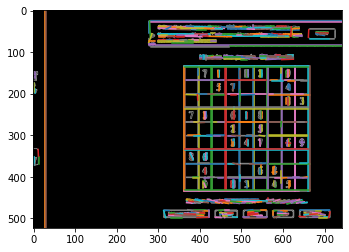

In [9]:

import math as m
rho_delta = 2 
theta_delta = 2.0 * m.pi / 180
vote_threshold = 10
lines = cv2.HoughLinesP(edge_im, rho_delta, theta_delta, vote_threshold, minLineLength=10,
                        maxLineGap=5)
print(lines.shape)
print(lines[0].shape)
for i,line in enumerate(lines):
    print(i, lines[i])
num_lines=lines.shape[0]
lines_reshaped = lines.reshape((num_lines,4))
x1 = lines_reshaped[:num_lines,0]
y1 = lines_reshaped[:num_lines,1]
x2 = lines_reshaped[:,2]
y2 = lines_reshaped[:,3]
# print(x1)
# print(x2)

ipu.show_gray_image_with_lines(edge_im, x1, y1, x2, y2)